<a href="https://colab.research.google.com/github/TheAcoff/Notebook-Alura/blob/main/Machine_Learning/Classif_Vendas_de_Carros_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vendas de Carros
- Árvore de Decisão
- Primeiras Validações

## Base de dados
Essa base de dados nos disponibiliza alguns dados de distância total percorrida, ano, preço de um carro e se ele foi vendido ou não.

In [1]:
uri = 'https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv'

In [2]:
import pandas as pd

dados = pd.read_csv(uri)
dados.head()

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes


Podemos trocar os nomes das colunas para ficar mais fácil para trabalhar.

In [3]:
mapa_rename = {
    'mileage_per_year':'milhas_por_ano',
    'model_year':'ano_modelo',
    'price':'preco',
    'sold':'vendido'
}
dados = dados.rename(columns = mapa_rename)
dados.columns

Index(['Unnamed: 0', 'milhas_por_ano', 'ano_modelo', 'preco', 'vendido'], dtype='object')

Temos então as colunas:
- `milhas_por_ano`: Distância total em milhas
- `ano_modelo`: Qual o ano do veículo
- `preco`: Preço do veículo
- `vendido`: Situação de venda

Com isso, podemos converter os valores para facilitar o aprendizado e entendimento do modelo. Faremos, primeiramente a alteração do status de venda para binário.


In [4]:
mapa_vendido = {
    'yes':1,
    'no':0
}
dados['vendido'] = dados['vendido'].map(mapa_vendido)
dados['vendido'].unique()

array([1, 0])

Criamos uma coluna para a idade do modelo.

In [5]:
from datetime import datetime

ano_atual = datetime.today().year

dados['idade_modelo'] = ano_atual - dados['ano_modelo']
dados.head()

,Unnamed: 0,milhas_por_ano,ano_modelo,preco,vendido,idade_modelo
0,0,21801,2000,30941.02,1,24
1,1,7843,1998,40557.96,1,26
2,2,7109,2006,89627.50,0,18
3,3,26823,2015,95276.14,0,9
4,4,7935,2014,117384.68,1,10


convertendo as coluna de milha para kilometro e limpando a base de dados

In [6]:
#Convertendo grandezas
dados['km_por_ano'] = 1.60934 * dados['milhas_por_ano']

#Limpando
dados = dados.drop(columns = ['Unnamed: 0', 'milhas_por_ano', 'ano_modelo'], axis = 1)

dados.head()

,preco,vendido,idade_modelo,km_por_ano
0,30941.02,1,24,35085.22134
1,40557.96,1,26,12622.05362
2,89627.50,0,18,11440.79806
3,95276.14,0,9,43167.32682
4,117384.68,1,10,12770.11290


<Axes: xlabel='idade_modelo', ylabel='preco'>

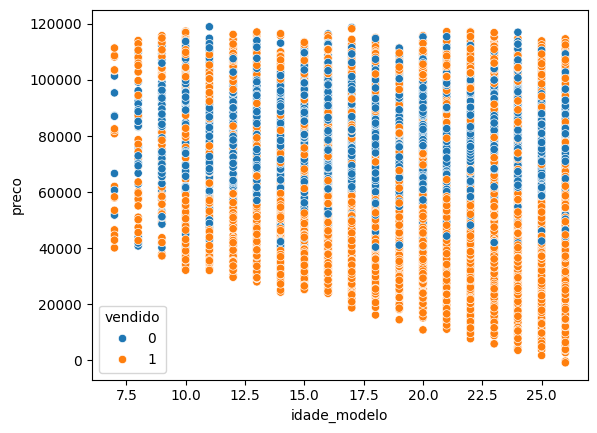

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data = dados, x='idade_modelo',y='preco', hue = 'vendido')

## Modelo Linear

Começamos fazendo o teste com um modelo de classificação linear

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

#Separando dados
x = dados[['preco', 'idade_modelo', 'km_por_ano']]
y = dados['vendido']

SEED = 32
np.random.seed(SEED)
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y,
                                                         test_size = 0.25, stratify = y)

print(f'Teremos {len(x_treino)} dados de treino e {len(x_teste)} dados de teste.')

modelo = LinearSVC()
modelo.fit(x_treino, y_treino)
previsoes = modelo.predict(x_teste)

acuracia = accuracy_score(y_teste, previsoes) * 100
print(f'A acurácia foi de {acuracia:.2f} %')

Teremos 7500 dados de treino e 2500 dados de teste.


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


A acurácia foi de 58.00 %


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Não sabemos se essa métrica está correta, para ajudar a conferir, vamos usar os Dummies Classifiers para verificar.

In [9]:
from sklearn.dummy import DummyClassifier

def dummy_classif(strategy):
  dummy = DummyClassifier(strategy = strategy)

  dummy.fit(x_treino, y_treino)
  previsoes = dummy.predict(x_teste)

  acuracia = dummy.score(y_teste, previsoes) * 100
  print(f'Usando dummies classifiers com "{strategy}", a acurácia foi de {acuracia:.2f} %')

In [10]:
dummy_classif('most_frequent')
dummy_classif('prior')
dummy_classif('stratified')
dummy_classif('uniform')

Usando dummies classifiers com "most_frequent", a acurácia foi de 100.00 %
Usando dummies classifiers com "prior", a acurácia foi de 100.00 %
Usando dummies classifiers com "stratified", a acurácia foi de 52.12 %
Usando dummies classifiers com "uniform", a acurácia foi de 49.36 %


Observamos que o modelo linear não seria uma boa alternativa.

# Árvore de Decisão
Muitos modelos de ML são como uma blackbox, não temos como prever as regras de decisão do modelo. Por isso, vamos utilizar uma Árvore de Decisão para visualizar melhor uma sequência de decisões.

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


SEED = 20
np.random.seed(SEED)
x_treino_raw, x_teste_raw, y_treino, y_teste = train_test_split(x, y,
                                                         test_size = 0.25, stratify = y)

print(f'Teremos {len(x_treino_raw)} dados de treino e {len(x_teste_raw)} dados de teste.')

# Modelo
modelo = DecisionTreeClassifier(max_depth = 3)
modelo.fit(x_treino_raw, y_treino)
previsoes = modelo.predict(x_teste_raw)


acuracia = accuracy_score(y_teste, previsoes) * 100
print(f'A acurácia foi de {acuracia:.2f} %')

Teremos 7500 dados de treino e 2500 dados de teste.
A acurácia foi de 78.40 %


criando uma visualização para as decisões.

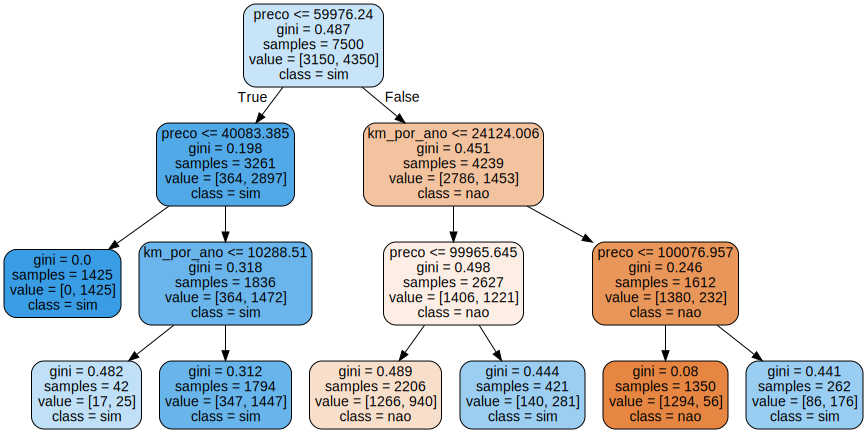

In [12]:
from sklearn.tree import export_graphviz
import graphviz

features = x.columns

dot_data = export_graphviz(modelo, out_file = None,
                           filled = True,
                           rounded = True,
                           feature_names = features,
                           class_names = ['nao','sim'])

grafico = graphviz.Source(dot_data)
grafico

Com isso, temos mais detalhes de quais parâmetros são utilizados para decidir a classe `class` se foi vendido (`class = sim`) ou não (`class = nao`). É interessante observar que primeiro ele usa como critério o preço e depois faz comparações de quilometragem por ano.

# Curso 2 - Validação de Modelos

Vamos usar validação cruzada para fazer uma validação. Usaremos o `cv = 5` recomendado pela documentação. (k-fold)

In [13]:
def imprimir_resultados(results):
  media = results['test_score'].mean()
  desvio_padrao = results['test_score'].std()
  print(f'Acurácia média = {media*100:.2f}')
  print(f'Acurácia, está entre: {(media - 2*desvio_padrao)*100:.2f}, {(media + 2*desvio_padrao)*100:.2f}')


In [14]:
from sklearn.model_selection import cross_validate

SEED = 250
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x, y, cv=5, return_train_score = False)
imprimir_resultados(results)

Acurácia média = 75.78
Acurácia, está entre: 75.21, 76.35


Podemos introduzir uma aleatoriedade nos kfolds, embaralhando os dados.

In [15]:
from sklearn.model_selection import cross_validate, KFold

SEED = 250
np.random.seed(SEED)

cv = KFold(n_splits = 10, shuffle = True)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x, y, cv = cv, return_train_score = False)
imprimir_resultados(results)

Acurácia média = 75.78
Acurácia, está entre: 73.33, 78.23


Antes de continuar, iremos gerar dados aleatórios para melhorar o treinamento e seleção de dados.

In [16]:
np.random.seed(SEED)

dados['modelo'] = dados['idade_modelo']+np.random.randint(-2,3, size = 10000)
dados.head()

,preco,vendido,idade_modelo,km_por_ano,modelo
0,30941.02,1,24,35085.22134,24
1,40557.96,1,26,12622.05362,24
2,89627.50,0,18,11440.79806,17
3,95276.14,0,9,43167.32682,9
4,117384.68,1,10,12770.11290,11


Temos então os seguintes valores

In [17]:
dados['modelo'].unique()

array([24, 17,  9, 11, 19, 21, 15, 26, 20,  6, 23, 13, 22, 18, 12, 16, 27,
       14, 25, 10,  7, 28,  8,  5])

Pode acontecer de ter valores negativos, vamos deixar pronto caso aconteça

In [18]:
dados['modelo'] = (abs(dados['modelo'].min())+dados['modelo']+1)
dados.head()

,preco,vendido,idade_modelo,km_por_ano,modelo
0,30941.02,1,24,35085.22134,30
1,40557.96,1,26,12622.05362,30
2,89627.50,0,18,11440.79806,23
3,95276.14,0,9,43167.32682,15
4,117384.68,1,10,12770.11290,17


Uma forma mais controlada é usando um Group KFold na implementação do cv. Com ele não ocorre o *overlap* dos grupos.

In [19]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate, KFold

SEED = 250
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)

modelo = DecisionTreeClassifier(max_depth = 2)
results = cross_validate(modelo, x, y, cv = cv, groups = dados['modelo'], return_train_score = False)
imprimir_resultados(results)


Acurácia média = 75.80
Acurácia, está entre: 70.49, 81.12
